# Imports

In [1]:
! pip install transformers
! pip install datasets
! pip install evaluate
! pip install sentencepiece
! pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 3.0 MB/s eta 0:00:00


In [2]:
! wget https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py

--2023-09-24 18:55:08--  https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7752 (7.6K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   7.57K  --.-KB/s    in 0s      

2023-09-24 18:55:09 (86.9 MB/s) - ‘helper_functions.py’ saved [7752/7752]



In [3]:
from helper_functions import calculate_results, plot_loss_curves, make_confusion_matrix

In [4]:
import tensorflow as tf
import numpy as np
from google.colab import drive
from google.colab import files
from datasets import load_dataset
import matplotlib.pyplot as plt
from transformers import (create_optimizer,T5TokenizerFast,DataCollatorForSeq2Seq,TFT5ForConditionalGeneration,
                          TFAutoModelForSeq2SeqLM,AutoModelForSeq2SeqLM,TFT5ForConditionalGeneration)

In [5]:
BATCH_SIZE = 64
MAX_LENGTH = 128

# Data loading

In [6]:
datset_id = 'leslyarun/c4_200m_gec_train100k_test25k'
dataset = load_dataset(datset_id)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['input', 'output'],
        num_rows: 25000
    })
})

In [8]:
dataset['train'][0]

{'input': 'Bitcoin is for $7,094 this morning, which CoinDesk says.',
 'output': 'Bitcoin goes for $7,094 this morning, according to CoinDesk.'}

# Tokenizer

In [9]:
model_id = 't5-small'
tokenizer = T5TokenizerFast.from_pretrained(model_id)

In [10]:
dataset['train'][0]

{'input': 'Bitcoin is for $7,094 this morning, which CoinDesk says.',
 'output': 'Bitcoin goes for $7,094 this morning, according to CoinDesk.'}

In [11]:
def preprocess_function(examples):
  inputs = [example for example in examples['input']]
  target = [example for example in examples['output']]
  tokenized_output = tokenizer(inputs, text_target=target, max_length=MAX_LENGTH, truncation=True)
  return tokenized_output

In [12]:
tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [13]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 25000
    })
})

In [14]:
# tokenized_dataset['train'][101]

In [16]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_id)

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, return_tensors='tf')

In [17]:
model.summary()

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  35330816  
                                                                 
 decoder (TFT5MainLayer)     multiple                  41625344  
                                                                 
Total params: 60506624 (230.81 MB)
Trainable params: 60506624 (230.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
train_dataset = tokenized_dataset['train'].to_tf_dataset(shuffle = True,
                                                        batch_size = BATCH_SIZE,
                                                        collate_fn = data_collator)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [19]:
test_dataset = tokenized_dataset['test'].to_tf_dataset(shuffle = True,
                                                      batch_size = BATCH_SIZE,
                                                      collate_fn = data_collator)

In [20]:
for i in test_dataset.take(1):
  print(i)

{'input_ids': <tf.Tensor: shape=(64, 128), dtype=int64, numpy=
array([[ 1813,    32,  6105, ...,     0,     0,     0],
       [   37,   239,   141, ...,     0,     0,     0],
       [   94,   764,   227, ...,     0,     0,     0],
       ...,
       [   37,  1812,  9029, ...,     0,     0,     0],
       [ 7486,    63, 25253, ...,     0,     0,     0],
       [   27,  1175,    82, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(64, 128), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>, 'labels': <tf.Tensor: shape=(64, 128), dtype=int64, numpy=
array([[   37,  1015,  3141, ...,  -100,  -100,  -100],
       [   37,   239,   141, ...,  -100,  -100,  -100],
       [   94,   764,   227, ...,  -100,  -100,  -100],
       ...,
       [   37,  1812,  9029, ...,  -100,  -100,  -100],
       [ 7486,   

In [24]:
num_epochs = 5
num_train_steps = len(train_dataset) * num_epochs
optimizer, schedule = create_optimizer(init_lr = 2e-5,
                                      num_warmup_steps = 0,
                                      num_train_steps = num_train_steps)
model.compile(optimizer=optimizer)

In [40]:
history = model.fit(train_dataset.take(500),
                   validation_data = test_dataset,
                   epochs = 5)

Epoch 1/5
500/500 [==============================] - 708s 1s/step - loss: 0.8938 - val_loss: 0.7913
Epoch 2/5
500/500 [==============================] - 649s 1s/step - loss: 0.8624 - val_loss: 0.7711
Epoch 3/5
500/500 [==============================] - 707s 1s/step - loss: 0.8487 - val_loss: 0.7585
Epoch 4/5
500/500 [==============================] - 706s 1s/step - loss: 0.8249 - val_loss: 0.7495
Epoch 5/5
500/500 [==============================] - 651s 1s/step - loss: 0.8129 - val_loss: 0.7423


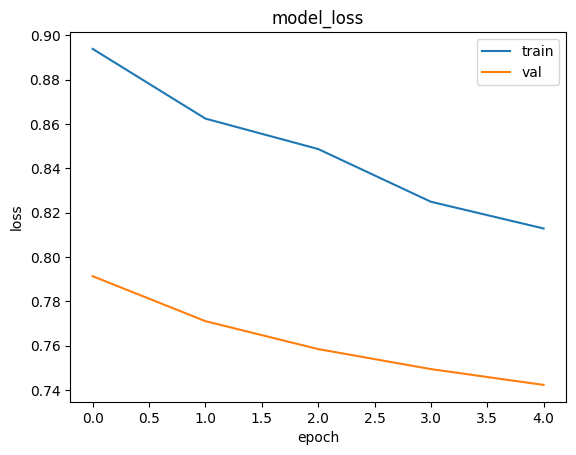

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

# Evaluation

In [42]:
! pip install sacrebleu

In [45]:
import sacrebleu

all_preds = []
all_labels = []

for batch in test_dataset.take(10):
    predictions = model.generate(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    all_preds.extend(decoded_preds)
    all_labels.extend(decoded_labels)

bleu_score = sacrebleu.corpus_bleu(all_preds, all_labels)
print(bleu_score)

BLEU = 0.34 9.4/0.2/0.1/0.1 (BP = 1.000 ratio = 13.300 hyp_len = 266 ref_len = 20)


# Model at inference

In [46]:
wrong_english = ["Dady hav'e eateing her foot",
                "DJ Sorryyouwastedyourmoneytobehere",
                "i used to like to swimming",
                "maybe we should organized a meetin with the people from unesco",
                "when are we goinge to start play football",
                "many a time rain fall in my city"]

inputs = tokenizer(wrong_english, padding="longest", max_length=128, truncation=True, return_tensors='tf')
output = model.generate(**inputs, max_length=128)
for i in range(len(wrong_english)):
    print(wrong_english[i] + " ------------> " + tokenizer.decode(output[i], skip_special_tokens=True))

Dady hav'e eateing her foot ------------> Dady hav'e eateing her foot.
DJ Sorryyouwastedyourmoneytobehere ------------> DJ Sorryyouwastedyourmoneytobehere
i used to like to swimming ------------> i used to like swimming.
maybe we should organized a meetin with the people from unesco ------------> maybe we should organize a meeting with the people from the unesco.
when are we goinge to start play football ------------> when are we going to start playing football?
many a time rain fall in my city ------------> many times rain fall in my city.


# Saving a Model

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model

In [48]:
model.save("Grammatical_Error_Correction")

In [ ]:
loaded_model = load_model("Grammatical_Error_Correction")

# Hugging Face

In [49]:
! pip install huggingface_hub

In [55]:
from huggingface_hub import notebook_login
notebook_login()

In [56]:
model.push_to_hub("DriveMyScream/Grammatical_Error_Correction")
tokenizer.push_to_hub("DriveMyScream/Grammatical_Error_Correction")

tf_model.h5:   0%|          | 0.00/374M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/DriveMyScream/Grammatical_Error_Correction/commit/07b025d67c946a7a6ce4aae77272cdbef05ec391', commit_message='Upload tokenizer', commit_description='', oid='07b025d67c946a7a6ce4aae77272cdbef05ec391', pr_url=None, pr_revision=None, pr_num=None)

In [57]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

pretrained_model = AutoModelForSeq2SeqLM.from_pretrained("DriveMyScream/Grammatical_Error_Correction", from_tf=True)
tokenizer = AutoTokenizer.from_pretrained("DriveMyScream/Grammatical_Error_Correction", from_tf=True)

All TF 2.0 model weights were used when initializing T5ForConditionalGeneration.

Some weights of T5ForConditionalGeneration were not initialized from the TF 2.0 model and are newly initialized: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
wrong_english = ["Dady hav'e eateing her foot",
                "DJ Sorryyouwastedyourmoneytobehere",
                "i used to like to swimming",
                "maybe we should organized a meetin with the people from unesco",
                "when are we goinge to start play football",
                "many a time rain fall in my city"]

inputs = tokenizer(wrong_english, padding="longest", max_length=128, truncation=True, return_tensors='pt')
output = pretrained_model.generate(**inputs, max_length=128)
for i in range(len(wrong_english)):
    print(wrong_english[i] + " ------------> " + tokenizer.decode(output[i], skip_special_tokens=True))

Dady hav'e eateing her foot ------------> Dady hav'e eateing her foot.
DJ Sorryyouwastedyourmoneytobehere ------------> DJ Sorryyouwastedyourmoneytobehere
i used to like to swimming ------------> i used to like swimming.
maybe we should organized a meetin with the people from unesco ------------> maybe we should organize a meeting with the people from the unesco.
when are we goinge to start play football ------------> when are we going to start playing football?
many a time rain fall in my city ------------> many times rain fall in my city.


# Tensorflow Lite

In [54]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_output_path = "Grammatical_Error_Correction.tflite"
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

In [ ]:
model_path = "/content/Grammatical_Error_Correction.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

wrong_english = ["Dady hav'e eateing her foot",
                "DJ Sorryyouwastedyourmoneytobehere",
                "i used to like to swimming",
                "maybe we should organized a meetin with the people from unesco",
                "when are we goinge to start play football",
                "many a time rain fall in my city"]

inputs = tokenizer(wrong_english, padding="longest", max_length=128, truncation=True, return_tensors='pt')
output = pretrained_model.generate(**inputs, max_length=128)
for i in range(len(wrong_english)):
    print(wrong_english[i] + " ------------> " + tokenizer.decode(output[i], skip_special_tokens=True))